# WZGW Projekt 1 - układy współrzędnych na elipsoidzie 
Nr indeksu: 311512

__Cel ćwiczenia:__ Zapoznanie się z układami współrzędnych na elipsoidzie obrotowej. Poznanie metod wizualizacji lotu samolotu na podstawie danych geodezyjnych.

__Układ geodezyjny:__ Układ współrzędnych, w którym do jednoznacznego wyznaczenia pozycji na elipsoidzie podajemy szerokość geodezyjną (oznaczana małą literą grecką _fi_), długość geodezyjną (oznaczana małą literą grecką _lambda_) i ewentualnie wysokość nad elipsoidą (oznaczana małą literą _h_). W każdym dowolnym punkcie na elipsoidzie szerokość (_latitude_) to kąt jaki tworzy prosta normalna z płaszczyzną równika (przedział -90 +90 stopni), długość (_longitude_) to kąt pomiędzy południkiem zerowym, a południkiem przechodzącym przez ten punkt. Wysokość mierzona jest w kierunku normalnej.

__Układ ortokartezjański:__ Układ współrzędnych, w którym do jednoznacznego wyznaczenia pozycji na elipsoidzie podajemy wartości x, y, z. Początek układu znajduje się w środku geometrycznym elipsoidy. Istnieją wzory matematyczne umożliwiające przejście pomiędzy układami.

__Układ topocentryczny:__ Układ współrzędnych, którego środek jest w dowolnie ustalonym punkcie na powierzchni elipsoidy. Względem tego punktu odpowiednio ustawione są osie __n__ (north), __e__ (east), __u__ (up). Nie ważne jaki punkt wybierzemy, każdy inny punkt na powierzchni elipsoidy będzie miał ujemną współrzędną __u__.
    
    x->n    y->e    z->u  
    
Zaimplementowałem funkcje do zamiany współrzędnych, które jako domyślne przyjmują parametry (mimośród, długoość półosi wielkiej) powszechnie używanej elipsoidy GRS 80, jednak można podać również parametry innych elipsoid obrotowych. Zastosowanie układu neu jest mniej praktyczne niż układu geodezyjnego w tym ćwiczeniu gdyż większość (jeśli nie wszystkie) funkcji z pythonowych modułów do wizualizacji danych geodezyjnych oczekuje danych postaci (_lambda_, _fi_). Jest to logiczne, ponieważ układ geodezyjny jest ogólnie najczęściej wykorzystywanym układem jeśli chodzi o dane geodezyjne. Natomiast układ topocentryczny "neu" przydał się do wizualizacji lotu samolotu z punktu odniesienia stacjonarnego obserwatora. Mając dane w tym układzie możemy też łatwo się dowiedzieć kiedy samolot zniknął za horyzontem (wystarzczy spojrzeć na znak współrzędnej _u_).

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import folium
from shapely.geometry import Point
# X, Y, Z - współrzędne geodezyjne, nie matematyczne...
%matplotlib inline
plt.style.use('seaborn-poster')
# sns.set_theme()

# Funkcje do zamiany współrzędnych

In [2]:
def delta_vector(A, B):
    """zwraca wektor delt między dwoma punktami A do B. A,B: np.array()"""
    if len(A) != len(B):
        print("A and B dimensions are not the same (they should be)")
        return
    delts = []
    for i in range(len(A)):
        delts.append(B[i]-A[i])
    return np.array(delts)

In [3]:
def geo2xyz(fi, lam, h, a=6378137, e2=0.00669437999013):
    # dorobic domusllne a i e2 dla elipsoidy GRS80
    """funkcja zamienia współrzędne geodezyjne na kartezjańskie fi, lam podajemy w radianach do wzorów, do fcji w deg"""
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    N = a / np.sqrt(1 - e2 * np.sin(fi) ** 2)
    x = (N + h) * np.cos(fi) * np.cos(lam)
    y = (N + h) * np.cos(fi) * np.sin(lam)
    z = (N * (1 - e2) + h) * np.sin(fi)
    return np.array([x, y, z])

In [4]:
def xyz2neu(fi, lam, A, B):
    # def xyz2neu(A:punktodniesienia/startowy, B:koniecwektora):
    """funkcja zamienia wsp kartezjańskie na topocentryczne neu
    A, B reprezentują punkty, A to początek, B to koniec wektora
    A, B są typu np.array i mają 3 współrzędne: x, y, z
    fi, lam to współrzędne punktu A potrzebne do macierzy obrotu"""
    # x, y, z -> north, east, up
    # fi, lambda, lotniska
    # wektor AB (od lotniska do samolotu)
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    rotation_matrix = np.array([
        [-1*np.sin(fi)*np.cos(lam), -1*np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-1*np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]
    ])
    vector = delta_vector(A, B)
    return rotation_matrix.transpose() @ vector

# Wczytanie i obróbka danych

In [5]:
orig_df = pd.read_csv('radar.csv', sep=';')
# orig_df = pd.read_csv('787_test_flight.csv', sep=';')

In [6]:
# orig_df.info()

In [7]:
# orig_df.describe(include='all')

In [8]:
# main_df.loc[0].xyz


In [9]:
main_df = orig_df
pd.set_option('display.max_colwidth', None)
main_df['xyz'] = pd.Series(map(geo2xyz, main_df['Latitude'], main_df['Longitude'], main_df['Meters']))

In [10]:
A = main_df.loc[0].xyz
latA = main_df.loc[0].Latitude
lonA = main_df.loc[0].Longitude
main_df['neu'] = pd.Series(map(xyz2neu, 
                               list(itertools.repeat(latA, main_df.shape[0])), 
                               list(itertools.repeat(lonA, main_df.shape[0])), 
                               list(itertools.repeat(A, 
                                                     main_df.shape[0])), 
                               main_df['xyz']
                              )
                          )

In [11]:
main_df['n'] = pd.Series(map(lambda x: x[0], main_df['neu']))

In [12]:
main_df['e'] = pd.Series(map(lambda x: x[1], main_df['neu']))

In [13]:
main_df['u'] = pd.Series(map(lambda x: x[2], main_df['neu']))

In [14]:
main_df['tanA'] = main_df['e']/main_df['n']

In [15]:
main_df['s'] = np.sqrt(main_df['n']**2 + main_df['e']**2 + main_df['u']**2)

In [16]:
main_df['cosz'] = main_df['u']/main_df['s']

In [17]:
# main_df

In [18]:
main_df.dropna(axis=0, how='all', thresh=4, inplace=True)

In [19]:
main_df

Latitude  Longitude  Meters  kmh  \
0     37.4806   126.4373     115  327   
1     37.4926   126.4277     298  333   
2     37.5041   126.4187     413  352   
3     37.5174   126.4078     474  391   
4     37.5421   126.3868     603  447   
..        ...        ...     ...  ...   
912   52.2403    20.9018     693  232   
913   52.2294    20.9113     523  232   
914   52.1966    20.9400     358  246   
915   52.1872    20.9483     282  253   
916   52.1786    20.9559     213  253   

                                                              xyz  \
0     [-3009986.9279177887, 4077087.335196061, 3859925.648851618]   
1     [-3008908.6770793367, 4077056.266483708, 3861093.862974308]   
2    [-3007861.0886884076, 4076977.0155891557, 3862176.543878538]   
3      [-3006580.627028365, 4076864.661696517, 3863384.693334532]   
4    [-3004156.090917171, 4076704.2115607024, 3865637.4877571473]   
..                                                            ...   
912    [3656694.4515809016, 1396487.460066755, 5019768.603065541]   
913      [3657261.3345508967, 1397398.8339414, 5018891.353449281]   
914     [3659160.510699166, 1400225.388276155, 5016524.526847928]   
915     [3659685.91079667, 1401034.2542547686, 5015823.264119978]   
916   [3660166.5031345594, 1401774.9245151733, 5015181.999035442]   

                                                              neu  \
0                                                 [0.0, 0.0, 0.0]   
1     [1331.9470955389904, -849.0076412188461, 182.8040803672484]   
2    [2608.5237439473776, -1644.7296614314967, 297.2532340053251]   
3    [4085.0349796828964, -2608.138642317193, 357.15544050526523]   
4      [6827.558751073275, -4463.397463245433, 482.7754303986262]   
..                                                            ...   
912  [4642061.251549246, -3771271.0104191685, -4147803.549780838]   
913  [4641123.827833245, -3772268.375818544, -4148022.6948631243]   
914  [4638548.288712385, -3775475.0883691357, -4148553.487162569]   
915   [4637785.71012491, -3776378.196672528, -4148711.4369574287]   
916  [4637087.933584854, -3777204.752453309, -4148855.2972366395]   

                n             e             u      tanA             s  \
0    0.000000e+00  0.000000e+00  0.000000e+00       NaN  0.000000e+00   
1    1.331947e+03 -8.490076e+02  1.828041e+02 -0.637418  1.590067e+03   
2    2.608524e+03 -1.644730e+03  2.972532e+02 -0.630521  3.098046e+03   
3    4.085035e+03 -2.608139e+03  3.571554e+02 -0.638462  4.859780e+03   
4    6.827559e+03 -4.463397e+03  4.827754e+02 -0.653733  8.171325e+03   
..            ...           ...           ...       ...           ...   
912  4.642061e+06 -3.771271e+06 -4.147804e+06 -0.812413  7.278426e+06   
913  4.641124e+06 -3.772268e+06 -4.148023e+06 -0.812792  7.278470e+06   
914  4.638548e+06 -3.775475e+06 -4.148553e+06 -0.813935  7.278794e+06   
915  4.637786e+06 -3.776378e+06 -4.148711e+06 -0.814263  7.278866e+06   
916  4.637088e+06 -3.777205e+06 -4.148855e+06 -0.814564  7.278933e+06   

         cosz  
0         NaN  
1    0.114966  
2    0.095949  
3    0.073492  
4    0.059082  
..        ...  
912 -0.569876  
913 -0.569903  
914 -0.569951  
915 -0.569967  
916 -0.569981  

[917 rows x 12 columns]

# Wizualizacja lotu
1. Mapa interaktywna
2. Trasa lotu
3. Nad którymi krajami przeleciał samolot?
4. Wykresy w układzie topocentrycznym neu
5. Więcej map 

### 1. Mapa interaktywna

In [20]:
m = folium.Map(location=[latA, lonA], tiles="OpenStreetMap", zoom_start=4, )
tilesy = ["OpenStreetMap", "Stamen Terrain", "Stamen Toner", "Stamen Watercolor", "CartoDB positron", "CartoDB dark_matter"]
for tilename in tilesy:
    folium.TileLayer(tilename, control=True).add_to(m)
folium.LayerControl().add_to(m);

In [21]:
def tooltipp(Latitude, Longitude):
    tekst = f"Latitude: {Latitude}" + "\n" + f"Longitude: {Longitude}"
    return tekst

In [22]:
def popupp(Lat, Lon, Meters, kmh, u):
    tekst = f"{Lat=}, {Lon=}, {Meters=}, {kmh=}, {u=}"
    return tekst

In [23]:
main_df.apply(lambda row: folium.Circle(location=[row['Latitude'], row['Longitude']],
                                        fill=True, 
                                        color="#f108f2" if row['u']>0 else "blue",
                                        radius=1500, 
                                        tooltip=tooltipp(row['Latitude'], row['Longitude']),
                                        popup=popupp(row['Latitude'], row['Longitude'], row['Meters'], row['kmh'], row['u'])
                                       ).add_to(m), axis=1
             );

# m.add_child(folium.LatLngPopup())

# m.save('mapka.html')  # save as html

In [24]:
m

### 2. Trasa lotu

In [25]:
gdf = gpd.GeoDataFrame(main_df, 
                       geometry=[Point(x, y) for x, y in zip(main_df['Longitude'], main_df['Latitude'])], 
                       crs="EPSG:4326")  # ,crs="EPSG:4326"

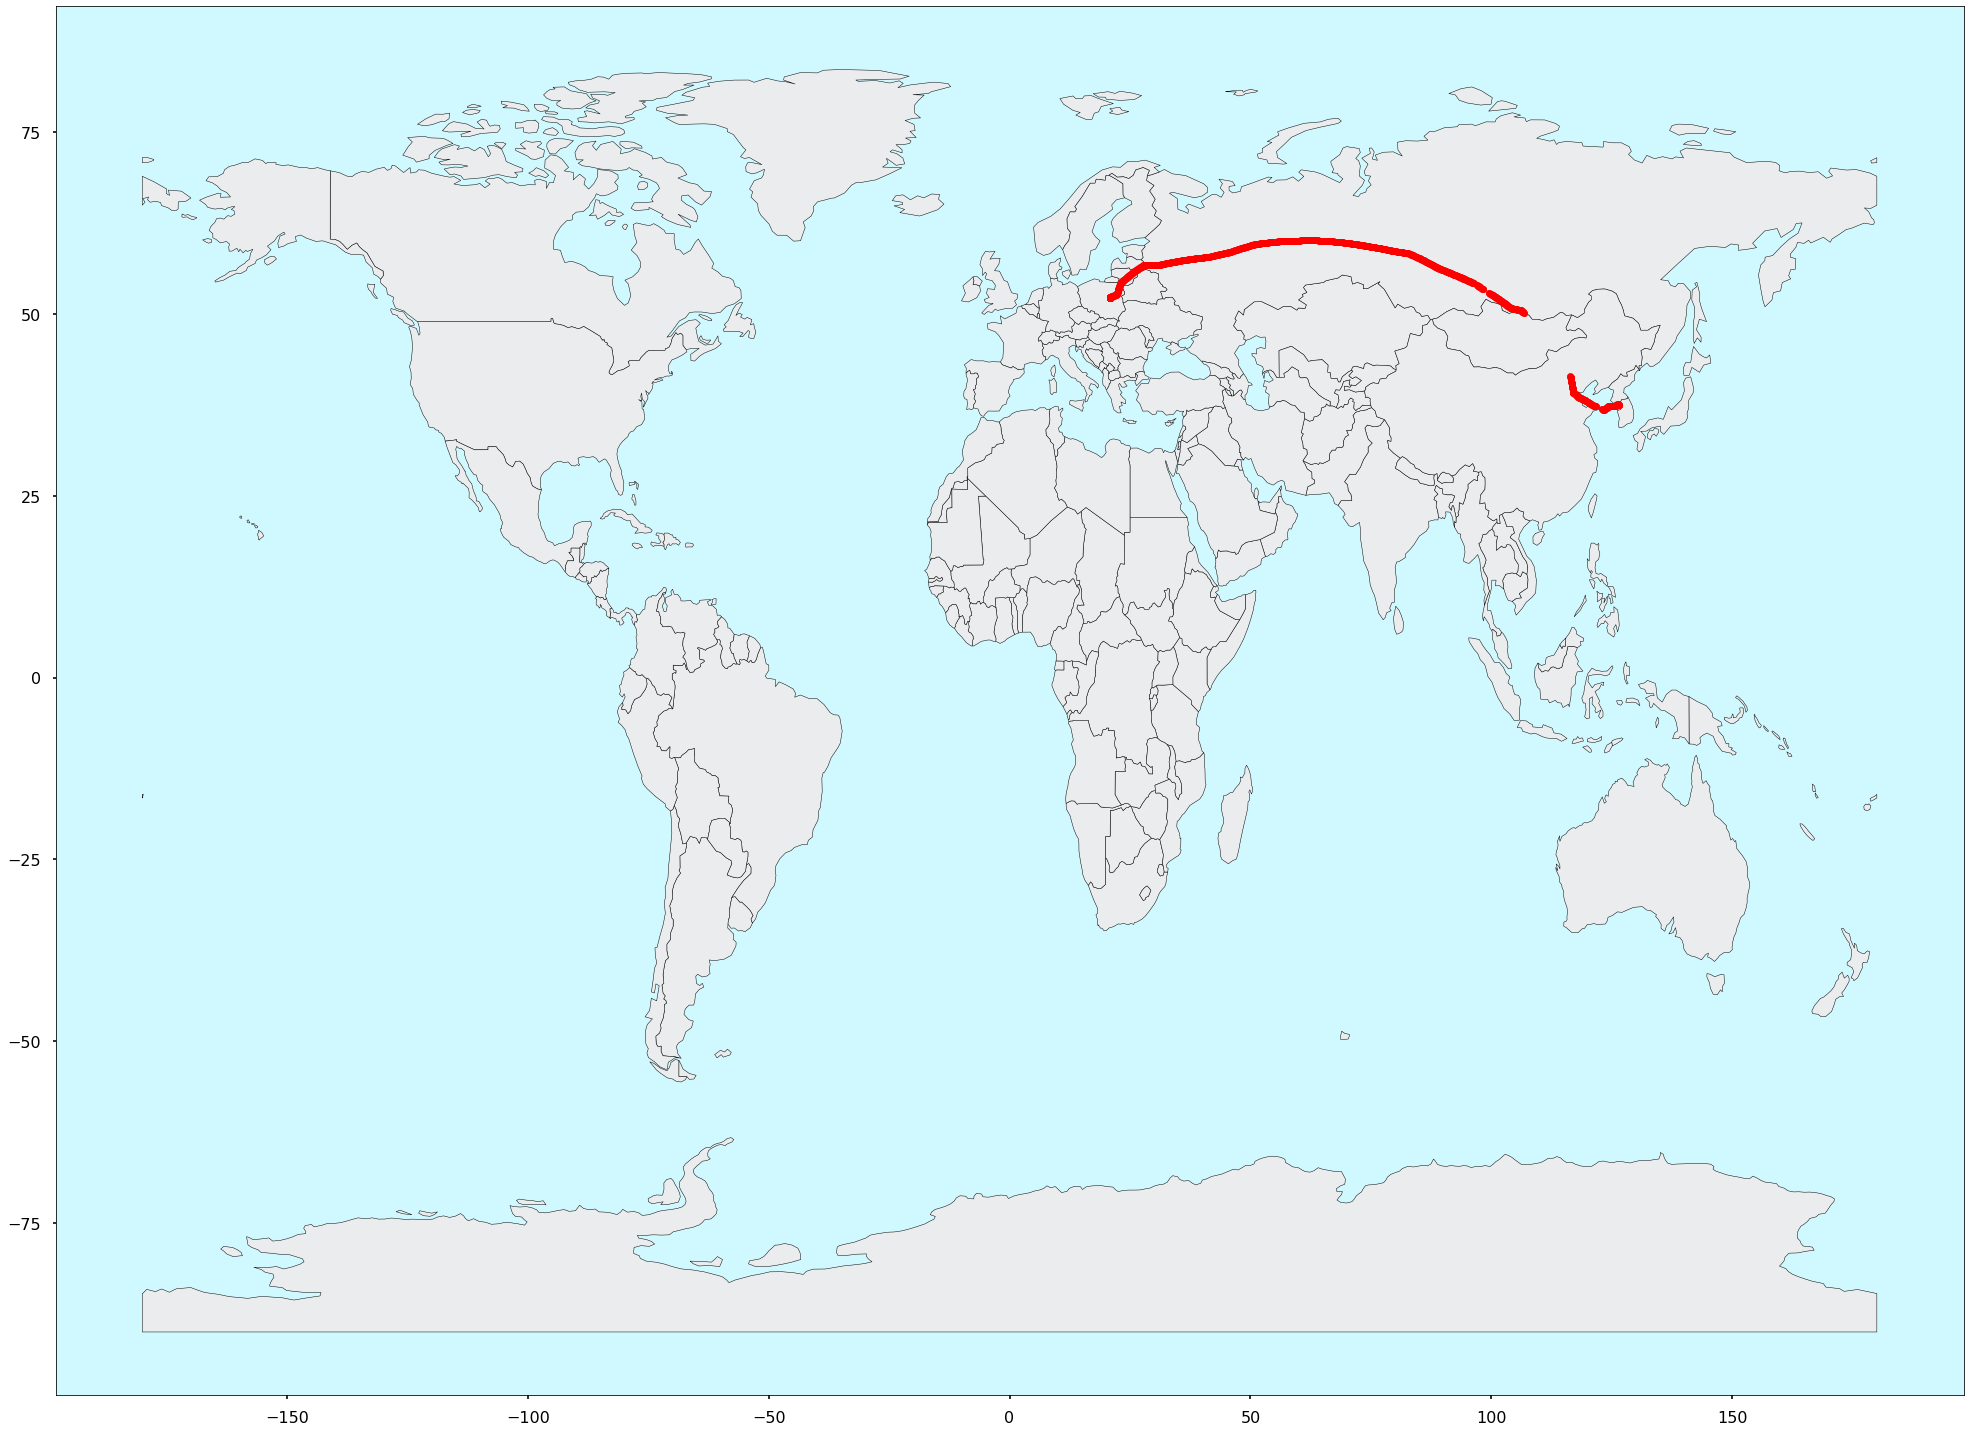

In [26]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(2560*px, 1440*px),)  # dpi=200
# ax.set_aspect('equal')
ax.set_facecolor('#d0f9ff')
# ax.set_axis_off();  fig.set_facecolor('#d0f9ff')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='#ebeced', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=40)

# plt.style.use('default')
# plt.style.use('seaborn-poster')
plt.tight_layout()

plt.show()

In [27]:
# gdf
# world

### 3. Nad którymi krajami przeleciał samolot?

In [28]:
multipunkt = gdf['geometry'].unary_union
filt = world['geometry'].intersects(multipunkt)
world['flewover'] = filt
world[filt].name

18          Russia
96     South Korea
97        Mongolia
113         Poland
118      Lithuania
119         Latvia
139          China
Name: name, dtype: object

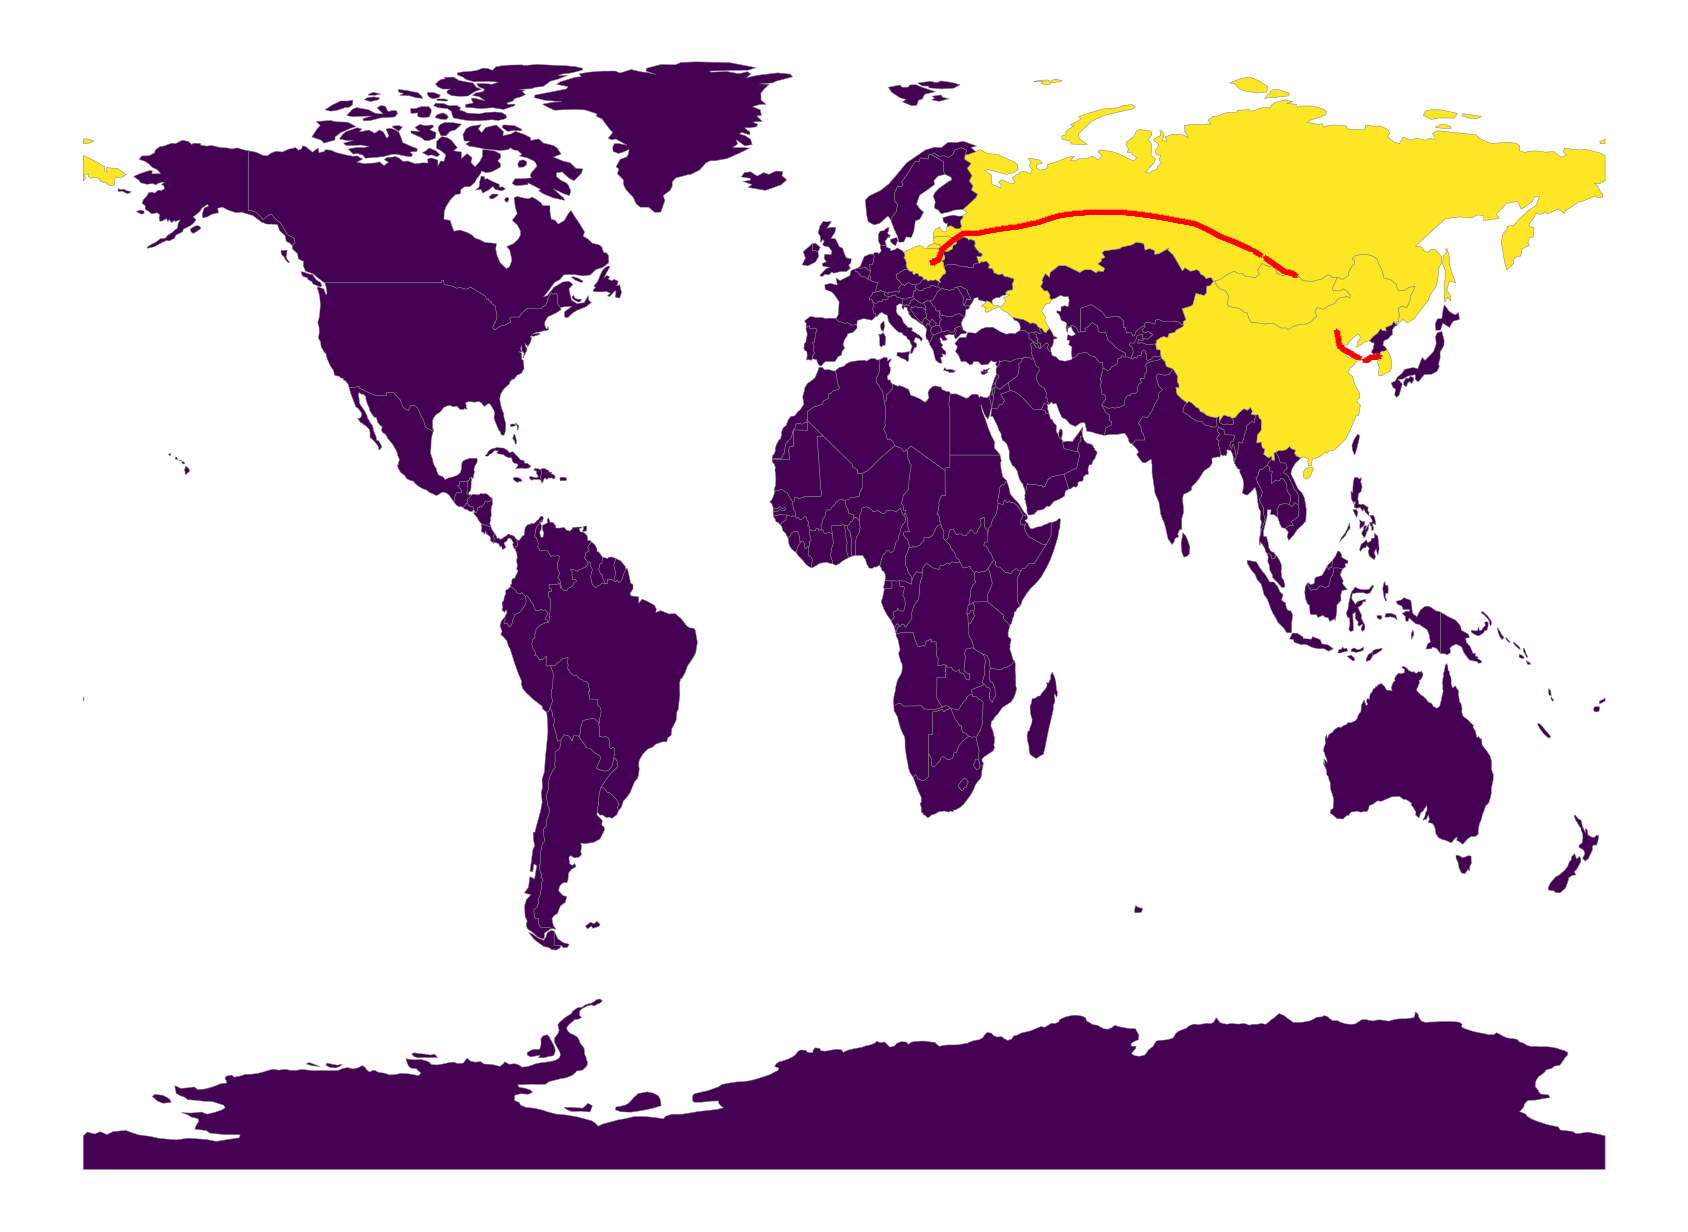

In [29]:
fig, ax = plt.subplots(figsize=(30,30))  # figsize=(,)
ax.set_aspect('equal')
# ax.set_facecolor('#d0f9ff')
ax.set_axis_off();  fig.set_facecolor('white')  #d0f9ff

world.plot(ax=ax, edgecolor='grey', column='flewover', legend=False, cmap=plt.cm.get_cmap('viridis', 2))  # 'Blues'
gdf.plot(ax=ax, marker='*', color='red', markersize=30)

# plt.savefig('mapka.png')  # save as png
plt.show()

### 4. Wykresy w układzie topocentrycznym neu

In [30]:
import plotly.express as px
fig = px.scatter_3d(main_df, y='n', x='e', z='u', color=main_df['u']>0, labels={"color": "u > 0"})

# plotly.offline.plot(fig, filename='neu.html', auto_open=False)  # save as html

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})  # , scene_aspectmode='data'
fig.show()

In [31]:
fig = px.line_3d(main_df, y='n', x='e', z='u', color=main_df['u']>0, labels={"color": "u > 0"},)
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})  # , scene_aspectmode='data'
fig.show()

### 5. Więcej map 

In [32]:
import plotly.express as px
import plotly
# px.set_mapbox_acces_token
fig = px.scatter_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     projection='conic equidistant'
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [33]:
fig = px.scatter_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     hover_data=['Meters', 'n', 'e', 'u', 's'],
                     projection='orthographic',
#                      animation_frame=main_df.index
                    )
fig.update_geos(fitbounds="locations")  # ,lataxis_showgrid=True, lonaxis_showgrid=True
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [34]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='orthographic',
                    )

fig.update_geos(showcountries=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [40]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='mercator',
                    )

fig.update_geos(showcountries=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [43]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='sinusoidal',  
                      # keeps horizontal lines up to scale, preserves area(same a on map = same irl)
                      # orientation and shape are way off
                    )

fig.update_geos(showcountries=True, lonaxis_showgrid=True, lataxis_showgrid=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [52]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='winkel tripel',  # similar distortion of shape, size, direction
                    )

fig.update_geos(showcountries=True, lonaxis_showgrid=True, lataxis_showgrid=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Wykresy

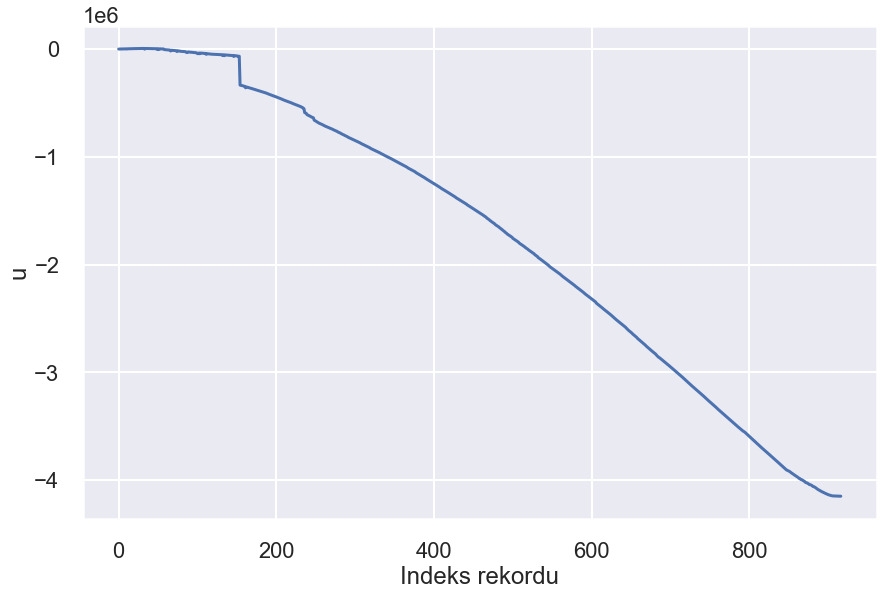

In [35]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['u'],)  # gdf.index[::-1]

plt.xlabel('Indeks rekordu')
plt.ylabel('u')

plt.tight_layout()
plt.show()

In [36]:
# gdf[gdf['u'] > -100]['u']  # .describe()

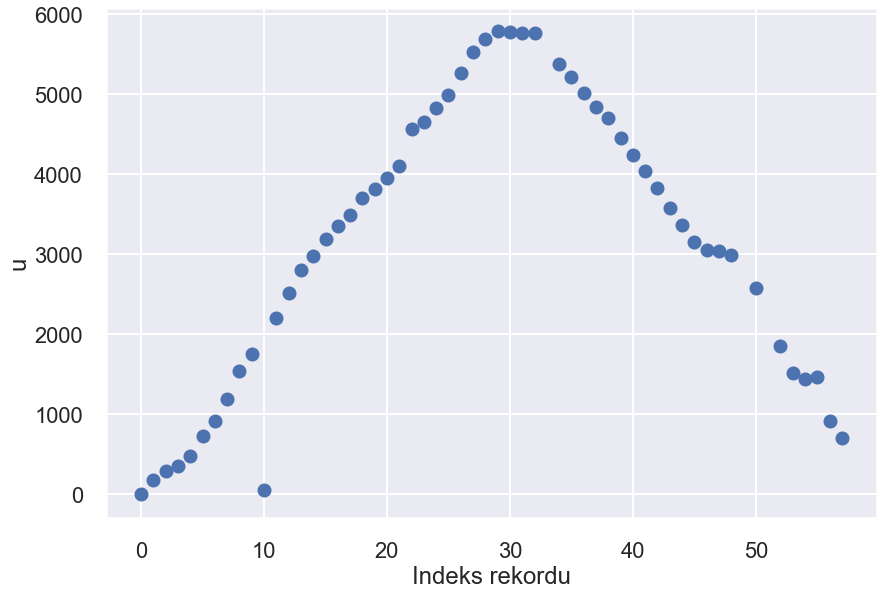

In [37]:
sns.set_theme(context='poster', style='darkgrid')

plt.scatter(gdf[gdf['u'] > -100]['u'].index, gdf[gdf['u'] > -100]['u'])

plt.xlabel('Indeks rekordu')
plt.ylabel('u')

plt.tight_layout()
plt.show()

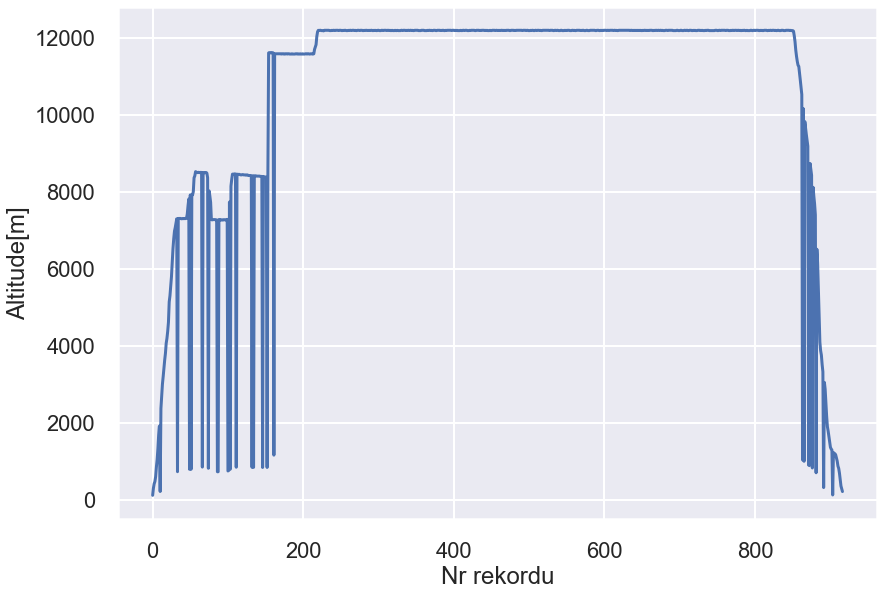

In [38]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['Meters'])

plt.xlabel('Nr rekordu')
plt.ylabel('Altitude[m]')

plt.tight_layout()
plt.show()

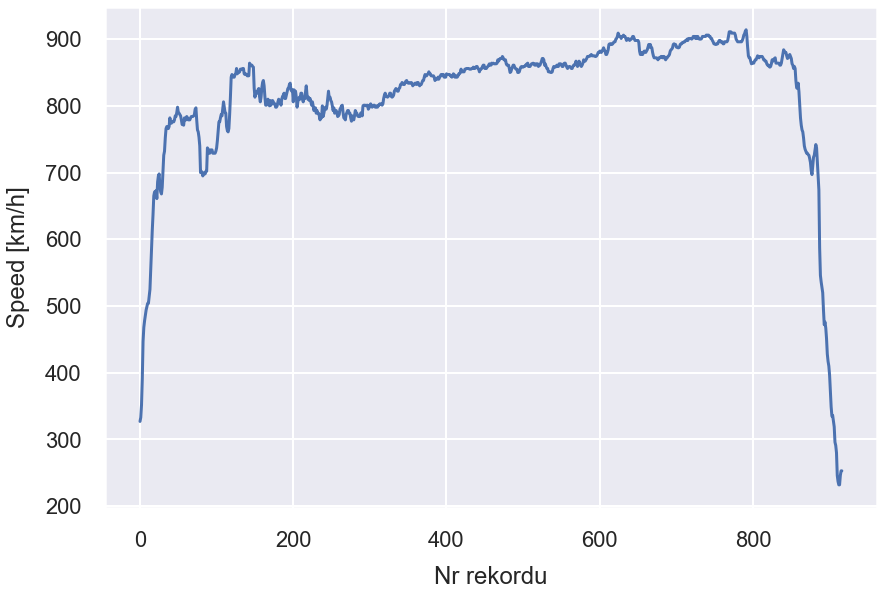

In [39]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['kmh'])

plt.xlabel('Nr rekordu', labelpad=15)
plt.ylabel('Speed [km/h]', labelpad=15)

plt.tight_layout()
plt.show()